# Tree Image Annotation with YOLOv8

In [1]:
from pathlib import Path
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import defaultdict

In [2]:
weights_path = Path("runs/tree_canopy/yolov8n-tree/weights/best.pt")
if not weights_path.exists():
    print(f"Custom weights not found at {weights_path}, falling back to pretrained yolov8n.pt")
    weights_path = Path("yolov8n.pt")
model = YOLO(str(weights_path))
names = model.names if isinstance(model.names, dict) else dict(enumerate(model.names))
print(f"Loaded model from {weights_path}")

Loaded model from runs\tree_canopy\yolov8n-tree\weights\best.pt


In [3]:
def annotate_trees_in_image(image_source, conf=0.25, imgsz=640, show=True, save_path=None):
    """Detect trees in a single image, draw green boxes, and optionally display/save the result."""
    results = model.predict(source=image_source, conf=conf, imgsz=imgsz, save=False, verbose=False)
    if not results:
        raise RuntimeError("Model did not return any predictions; verify the image source.")
    result = results[0]
    if result.orig_img is not None:
        annotated = result.orig_img.copy()
    else:
        if isinstance(image_source, (str, Path)):
            image_path = Path(image_source)
            annotated = cv2.imread(str(image_path))
            if annotated is None:
                raise FileNotFoundError(f"Unable to read image from {image_path}")
        else:
            raise ValueError("Provide a file path or an array-like image for prediction.")
    boxes = result.boxes
    tree_count = 0
    if boxes is not None and len(boxes) > 0:
        xyxy = boxes.xyxy.cpu().numpy().astype(int)
        confidences = boxes.conf.cpu().numpy()
        class_ids = boxes.cls.cpu().numpy().astype(int)
        tree_count = len(xyxy)
        for (x1, y1, x2, y2), cls_id, conf_score in zip(xyxy, class_ids, confidences):
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f"{names.get(cls_id, 'tree')} {conf_score:.2f}"
            cv2.putText(annotated, label, (x1, max(y1 - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)
    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        cv2.imwrite(str(save_path), annotated)
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
        legend_patch = Patch(color="#00FF00", label=f"Trees detected: {tree_count}")
        plt.legend(handles=[legend_patch], loc="lower right", frameon=True)
        plt.axis("off")
        plt.show()
    return annotated, tree_count

In [4]:
def annotate_trees_in_video(source, output_path, conf=0.25, imgsz=640, show=False):
    """Detect trees frame-by-frame from an OpenCV-readable source and save annotated MP4 output."""
    cap = cv2.VideoCapture(source)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video source {source}")
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    fps = cap.get(cv2.CAP_PROP_FPS) or 20.0
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    output_path = Path(output_path).expanduser().resolve()
    output_path.parent.mkdir(parents=True, exist_ok=True)
    writer = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))
    if not writer.isOpened():
        cap.release()
        raise RuntimeError(f"Unable to create video writer at {output_path}")
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            results = model.predict(source=frame, conf=conf, imgsz=imgsz, save=False, verbose=False)
            annotated = frame.copy()
            tree_count = 0
            if results:
                result = results[0]
                boxes = result.boxes
                if boxes is not None and len(boxes) > 0:
                    xyxy = boxes.xyxy.cpu().numpy().astype(int)
                    confidences = boxes.conf.cpu().numpy()
                    class_ids = boxes.cls.cpu().numpy().astype(int)
                    tree_count = len(xyxy)
                    for (x1, y1, x2, y2), cls_id, conf_score in zip(xyxy, class_ids, confidences):
                        cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        label = f"{names.get(cls_id, 'tree')} {conf_score:.2f}"
                        cv2.putText(annotated, label, (x1, max(y1 - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
            cv2.putText(annotated, f"Trees: {tree_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2, cv2.LINE_AA)
            writer.write(annotated)
            if show:
                cv2.imshow("Tree Counter", annotated)
                key = cv2.waitKey(1) & 0xFF
                if key in (ord('q'), 27):
                    break
        if show:
            cv2.destroyAllWindows()
    finally:
        cap.release()
        writer.release()
    return str(output_path)

In [5]:
def annotate_unique_trees_in_video(source, output_path, conf=0.25, imgsz=640, show=False):
    """Detect and count each unique tree once using YOLO + built-in tracking."""
    cap = cv2.VideoCapture(source)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video source {source}")
    
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    fps = cap.get(cv2.CAP_PROP_FPS) or 20.0
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    output_path = Path(output_path).expanduser().resolve()
    output_path.parent.mkdir(parents=True, exist_ok=True)
    writer = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))

    if not writer.isOpened():
        cap.release()
        raise RuntimeError(f"Unable to create video writer at {output_path}")

    seen_ids = set()  # To store unique track IDs
    total_unique_trees = 0

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Run detection + tracking in one step
            results = model.track(source=frame, conf=conf, imgsz=imgsz, persist=True, verbose=False)

            annotated = frame.copy()

            if results and results[0].boxes is not None:
                boxes = results[0].boxes
                xyxy = boxes.xyxy.cpu().numpy().astype(int)
                confidences = boxes.conf.cpu().numpy()
                class_ids = boxes.cls.cpu().numpy().astype(int)
                track_ids = boxes.id.cpu().numpy().astype(int) if boxes.id is not None else []

                for (x1, y1, x2, y2), cls_id, conf_score, track_id in zip(xyxy, class_ids, confidences, track_ids):
                    label = f"Tree {track_id} ({conf_score:.2f})"
                    cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(annotated, label, (x1, max(y1 - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

                    # Count each unique tree only once
                    if track_id not in seen_ids:
                        seen_ids.add(track_id)
                        total_unique_trees += 1

            cv2.putText(annotated, f"Unique Trees: {total_unique_trees}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

            writer.write(annotated)
            if show:
                cv2.imshow("Tree Counter", annotated)
                if cv2.waitKey(1) & 0xFF in (ord('q'), 27):
                    break

        if show:
            cv2.destroyAllWindows()

    finally:
        cap.release()
        writer.release()

    return str(output_path)


### Further Approximations

In [6]:
def estimate_carbon_sequestration(tree_count,
                                  biomass_values=(50, 250, 500, 1000),
                                  annual_rates=(2, 10, 25),
                                  carbon_fraction=0.5):
    """
    Estimate carbon sequestration (stock + annual flow) using only the number of trees.

    Parameters:
        tree_count (int): Number of detected trees.
        biomass_values (tuple): Dry biomass per tree (kg) for low/med/high assumptions.
        annual_rates (tuple): Annual carbon uptake per tree (kg C/year).
        carbon_fraction (float): Carbon fraction of dry biomass (default 0.5).

    Returns:
        dict: {
            "stock": {
                "per_tree_CO2e": [... kg],
                "total_CO2e": [... kg]
            },
            "annual": {
                "per_tree_CO2e": [... kg/year],
                "total_CO2e": [... kg/year]
            }
        }

    Example:
        If tree_count = 1000 and biomass_values = (50, 250, 500):
            For B=500:
                carbon = 500 * 0.5 = 250 kg C
                CO2e  = 250 * (44/12) ≈ 916.7 kg CO2 per tree
                Total = 916.7 * 1000 ≈ 916,700 kg CO2 (≈ 916.7 tonnes)
    """

    CO2_CONVERSION = 44 / 12  # ≈ 3.6667

    # --- A. STOCK ESTIMATION (TOTAL STORED CARBON) ---
    stock_per_tree = []
    stock_total = []

    for B in biomass_values:
        carbon_kg = B * carbon_fraction
        co2e_per_tree = carbon_kg * CO2_CONVERSION
        total_co2e = co2e_per_tree * tree_count
        stock_per_tree.append(co2e_per_tree)
        stock_total.append(total_co2e)

    # --- B. ANNUAL SEQUESTRATION (FLOW) ---
    annual_per_tree = []
    annual_total = []

    for r in annual_rates:
        co2e_per_tree_year = r * CO2_CONVERSION
        total_co2e_year = co2e_per_tree_year * tree_count
        annual_per_tree.append(co2e_per_tree_year)
        annual_total.append(total_co2e_year)

    return {
        "stock": {
            "assumptions_biomass": biomass_values,
            "per_tree_CO2e_kg": stock_per_tree,
            "total_CO2e_kg": stock_total
        },
        "annual": {
            "assumptions_annual_rate": annual_rates,
            "per_tree_CO2e_kg_per_year": annual_per_tree,
            "total_CO2e_kg_per_year": annual_total
        }
    }


In [7]:
def estimate_oxygen_output(tree_count: int, age_group: str = "mature"):
    """
    Estimate the annual oxygen (O₂) production based on number of trees.

    Parameters:
        tree_count (int): Number of detected trees.
        age_group (str): Tree age category; one of ["young", "medium", "mature"].
                         young  -> 5–20 kg/year
                         medium -> 40–80 kg/year
                         mature -> 100–120 kg/year (default)

    Returns:
        dict: {
            "tree_count": int,
            "age_group": str,
            "o2_per_tree_range": (min, max),
            "estimated_o2_total_range": (min_total, max_total),
            "estimated_o2_average": avg_total
        }
    """

    age_group = age_group.lower()

    # Define oxygen ranges per tree (kg/year)
    oxygen_map = {
        "young":  (5, 20),
        "medium": (40, 80),
        "mature": (100, 120)
    }

    if age_group not in oxygen_map:
        raise ValueError(f"Invalid age_group '{age_group}'. Use young/medium/mature.")

    per_tree_min, per_tree_max = oxygen_map[age_group]

    # Total O₂ range
    total_min = tree_count * per_tree_min
    total_max = tree_count * per_tree_max
    total_avg = tree_count * ((per_tree_min + per_tree_max) / 2)

    return {
        "tree_count": tree_count,
        "age_group": age_group,
        "o2_per_tree_range": (per_tree_min, per_tree_max),
        "estimated_o2_total_range": (total_min, total_max),
        "estimated_o2_average": total_avg
    }


In [8]:
def estimate_pm_capture(
    tree_count: int,
    pm_per_tree_low: float = 0.10,    # kg/year per tree (lower bound)
    pm_per_tree_typ: float = 0.15,    # kg/year per tree (typical)
    pm_per_tree_high: float = 1.0,    # kg/year per tree (upper bound)
    use_deposition=False,
    C=None,            # µg/m³ (ambient PM concentration)
    Vd=None,           # m/s (deposition velocity)
    canopy_area=None   # m² (per tree)
):
    """Estimate PM captured per year using simple rule-of-thumb or deposition model."""

    estimates = {
        "tree_count": tree_count,
        "simple_method": {
            "low_kg_per_year": tree_count * pm_per_tree_low,
            "typical_kg_per_year": tree_count * pm_per_tree_typ,
            "high_kg_per_year": tree_count * pm_per_tree_high
        }
    }

    if use_deposition:
        if C is None or Vd is None or canopy_area is None:
            raise ValueError("For deposition model, provide C, Vd, and canopy_area.")

        T = 31_536_000  # seconds per year
        pm_tree_year = (Vd * C * canopy_area * T) / 1_000_000  # µg → kg

        estimates["deposition_model"] = {
            "pm_per_tree_kg_per_year": pm_tree_year,
            "pm_total_kg_per_year": pm_tree_year * tree_count,
            "inputs": {"C": C, "Vd": Vd, "canopy_area": canopy_area}
        }

    return estimates


# Usage
- Run Cells 1-3 to load dependencies and the trained model weights.
- `annotate_trees_in_image("/path/to/image.jpg")` draws boxes and returns the annotated array and count.
- `annotate_trees_in_video("/path/to/video.mp4", "./annotated.mp4")` processes each frame, overlays the count, and saves an MP4.
- Adjust `conf` or `imgsz` as needed for your imagery.
- Pass `show=True` to preview video frames in a window (press `q`/`Esc` to quit early).

In [9]:
# Example: annotate a single image
# annotated_image, tree_total = annotate_trees_in_image("./test/hq720.jpg", conf=0.25, imgsz=640, save_path="./annotatedJungleShot.jpg")
# print(f"Trees detected: {tree_total}")



In [10]:
# Example: annotate a video and save as MP4
# output_video_path = annotate_trees_in_video("./test.mp4", "./annotatedTestVideo.mp4", conf=0.25, imgsz=640, show=False)
# print(f"Annotated video saved to: {output_video_path}")

In [11]:
# Exaple: annotate a video counting unique trees only once
# output_video_path = annotate_unique_trees_in_video("./test/test.mp4", "./test/annotatedTestVideo.mp4", conf=0.25, imgsz=640, show=False)
# print(f"Annotated unique video saved to: {output_video_path}")

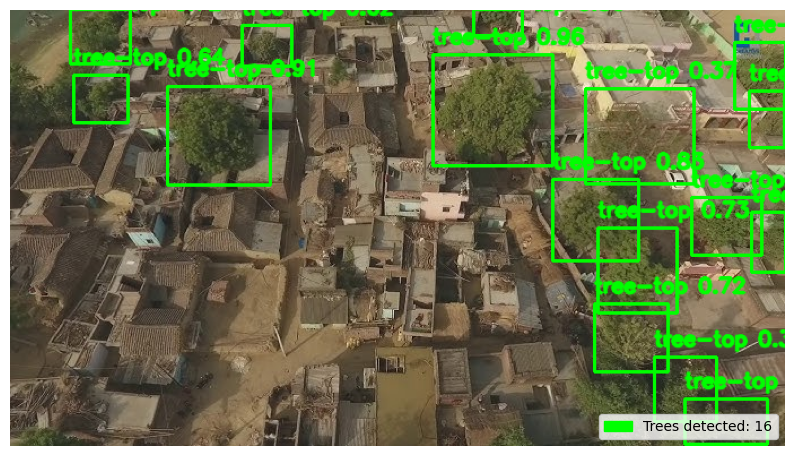

Trees detected: 16
{'stock': {'assumptions_biomass': (50, 250, 500, 1000), 'per_tree_CO2e_kg': [91.66666666666666, 458.3333333333333, 916.6666666666666, 1833.3333333333333], 'total_CO2e_kg': [1466.6666666666665, 7333.333333333333, 14666.666666666666, 29333.333333333332]}, 'annual': {'assumptions_annual_rate': (2, 10, 25), 'per_tree_CO2e_kg_per_year': [7.333333333333333, 36.666666666666664, 91.66666666666666], 'total_CO2e_kg_per_year': [117.33333333333333, 586.6666666666666, 1466.6666666666665]}}
{'tree_count': 16, 'age_group': 'mature', 'o2_per_tree_range': (100, 120), 'estimated_o2_total_range': (1600, 1920), 'estimated_o2_average': 1760.0}
{'tree_count': 16, 'simple_method': {'low_kg_per_year': 1.6, 'typical_kg_per_year': 2.4, 'high_kg_per_year': 16.0}}


In [13]:
# Example: annotate a single image
annotated_image, tree_total = annotate_trees_in_image("./test/hq720.jpg", conf=0.25, imgsz=640, save_path="./annotatedJungleShot.jpg")
print(f"Trees detected: {tree_total}")
carbon_report = estimate_carbon_sequestration(tree_total)
print(carbon_report)
oxygen_report = estimate_oxygen_output(tree_total, age_group="mature")
print(oxygen_report)
pm_est = estimate_pm_capture(tree_total)
print(pm_est)